# Week 3 Box Jenkins Models
## Time Series Analysis
### Earnest Salgado
### ID 12285784

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')

## 1. 30 pts - Regression Analysis

### 1.A - 5 pts Perform EDA (numerical, visual, descriptive)

In [2]:
df = pd.read_csv('hw3_data.csv', parse_dates = ['date'])

In [3]:
df

,date,gdp,urate
0,1948-01-01,265.742,3.4
1,1948-04-01,272.567,3.9
2,1948-07-01,279.196,3.6
3,1948-10-01,280.366,3.7
4,1949-01-01,275.034,4.3
...,...,...,...
287,2019-10-01,21747.394,3.6
288,2020-01-01,21561.139,3.5
289,2020-04-01,19520.114,14.8
290,2020-07-01,21170.252,10.2


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gdp,292.0,6481.725808,6487.790355,265.742,802.66925,4046.9255,11011.904,21747.394
urate,292.0,5.779110,1.743680,2.600,4.50000,5.6000,6.825,14.800


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    292 non-null    datetime64[ns]
 1   gdp     292 non-null    float64       
 2   urate   292 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 7.0 KB


In [6]:
df.isnull().sum()

date     0
gdp      0
urate    0
dtype: int64

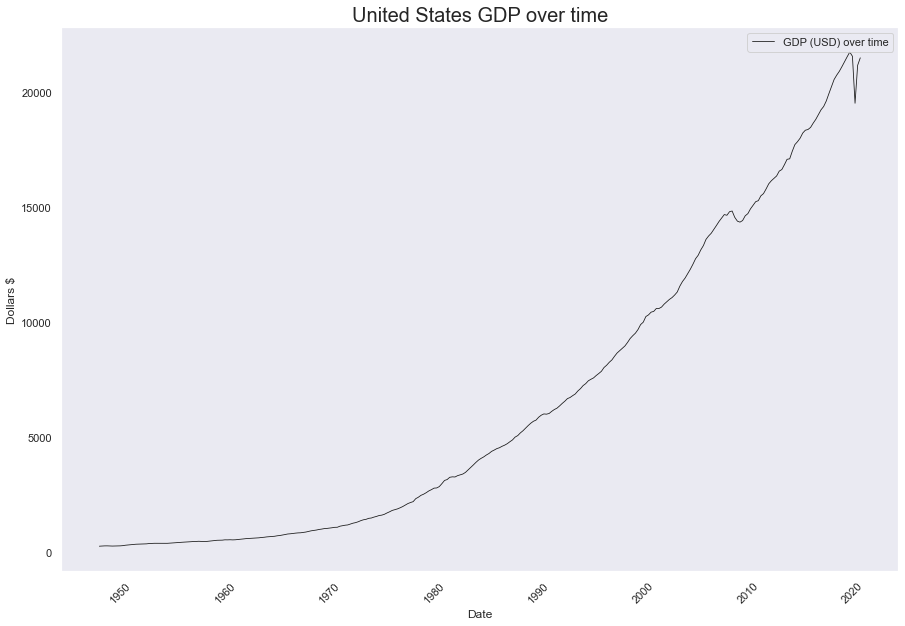

In [7]:
x = df['date']
#x = pd.to_datetime(x)

y = df['gdp']
# z = df['urate']

plt.figure(figsize=(15,10))  
plt.plot(x, y, color = 'k',label = "GDP (USD) over time", ls = '-', lw = 0.8)
#plt.plot(x, z, color = 'g',label = "SPY Price over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Dollars $')
plt.title('United States GDP over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

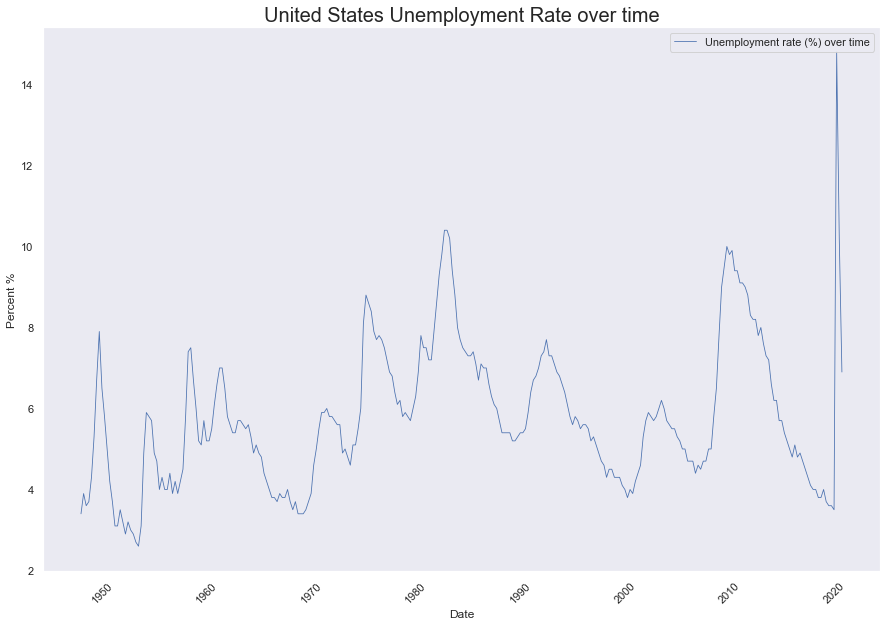

In [8]:
x = df['date']
z = df['urate']

plt.figure(figsize=(15,10))  
plt.plot(x, z, color = 'b',label = "Unemployment rate (%) over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Percent %')
plt.title('United States Unemployment Rate over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

In [9]:
# correlation table with all the numeric features
df.corr()

,gdp,urate
gdp,1.00000,0.14432
urate,0.14432,1.00000


<AxesSubplot:>

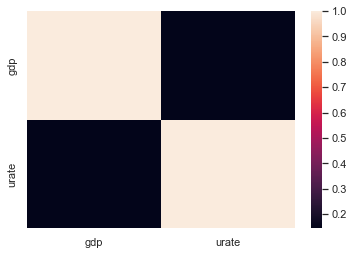

In [10]:
# heatmap based on the correlation table from above
sns.heatmap(df.corr())

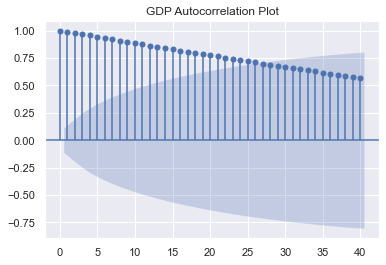

In [11]:
p = plot_acf(df['gdp'], lags=40, title='GDP Autocorrelation Plot')

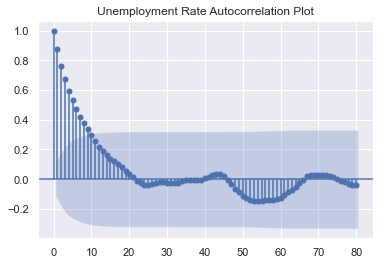

In [12]:
p = plot_acf(df['urate'], lags=80, title='Unemployment Rate Autocorrelation Plot')

### 1.B - 5 pts What is Okun’s Law? Does our dataset fit what we would expect to see? Why or why not?
- Okun's law looks at the statistical relationship between a country's unemployment and economic growth rates. Okun's law says that a country's gross domestic product (GDP) must grow at about a 4% rate for one year to achieve a 1% reduction in the rate of unemployment.


### 1.C - 5 pts Create a column that shows GDP change as a percentage and a column that shows UE rate as a change in percentage points. For date 4/1/1948 GDP change = 2.568, UE diff = 0.5

In [13]:
# set date as index
df.set_index('date', inplace = True)
# create new columns
df['gdp_pct_change'] = df['gdp'].pct_change()*100
df['urate_pct_pt_chg'] = df['urate'].diff()

df.head(len(df))
print(df.dtypes)

gdp                 float64
urate               float64
gdp_pct_change      float64
urate_pct_pt_chg    float64
dtype: object


In [14]:
# drop first row since it has NaN
df.dropna(subset = ['gdp_pct_change', 'urate_pct_pt_chg'], how='any',inplace=True)
df

,gdp,urate,gdp_pct_change,urate_pct_pt_chg
date,,,,
1948-04-01,272.567,3.9,2.568281,0.5
1948-07-01,279.196,3.6,2.432063,-0.3
1948-10-01,280.366,3.7,0.419060,0.1
1949-01-01,275.034,4.3,-1.901800,0.6
1949-04-01,271.351,5.3,-1.339107,1.0
...,...,...,...,...
2019-10-01,21747.394,3.6,0.961309,0.0
2020-01-01,21561.139,3.5,-0.856447,-0.1
2020-04-01,19520.114,14.8,-9.466221,11.3


### 1.D - 5 pts Split into Train/test ( ) and create a scatterplot, verifying the negative relationship in Okun’s law.

In [15]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(df)

In [16]:
y_train.index.min(), y_train.index.max()
y_test.index.min(), y_test.index.max()

(Timestamp('2002-10-01 00:00:00'), Timestamp('2020-10-01 00:00:00'))

In [17]:
print(y_train.shape)
print(y_test.shape)

(218, 4)
(73, 4)


gdp                -0.031490
urate               0.127573
gdp_pct_change     -0.528613
urate_pct_pt_chg    1.000000
Name: urate_pct_pt_chg, dtype: float64


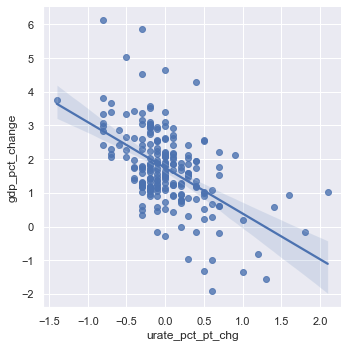

In [18]:
#df.plot.scatter(x='date', y='gdp', c='DarkBlue', title='GDP Over Time')
sns.lmplot(data = y_train, x = 'urate_pct_pt_chg', y = 'gdp_pct_change')
print(y_train.corr()['urate_pct_pt_chg'])

### 1.E - 5 pts Fit a linear model on the Training set. State Okun’s law using your data e.g. interpret the coefficients.

In [19]:
#from sklearn.linear_model import LinearRegression
#X = y_train['urate_pct_pt_chg'].values
#y = y_train['gdp_pct_change'].values

#lm = LinearRegression()
#lm_model = lm.fit(X.reshape(-1,1),y)

### 1.F - 5pts How can we use this model to predict level of GDP dollars in the future? What will we need, what are the resulting limitations?
- 

### Unfortunately, we have not yet learned how to fit Box-Jenkins models for multivariate time series. Thus, we will follow the Model identification procedure found in Week 3 slides for EACH of the economic time series in the dataset. Start with the original time series data: GDP in dollars and UE rate

## 2. 30 pts – Box Jenkins model for GDP
### 2.A - 7 pts Perform transformations or differencing until you can visually and statistically confirm stationarity on training set. Summarize the changes to your time series.
- When initially loading the original time series data for GDP, we can immediately notice it has an upward trend and changing mean/variance. Thus it is not showing stationarity
- When we do a first differencing, the upward trend begins to dampen however it is still visible.
- After a second differencing, the plot is observed to remain around zero for most of the time, a characteristic of stationarity. We can then confirm stationarity in the dataset by employing KPSS and ADFuller tests. 
- ADF test are shows the p-values are less than 0.05 so the Null hypothesis can be rejected. If it is not null then we know the TS does npt possess a unit root and hence is stationary. Rejecting the Null hypothesis would mean TS is not stationary.
- KPSS tests are showing that the p-values are greater than 0.05. This means that the Null hypothesis of stationarity cannot be rejected. If it is null then we know the TS has stationary characteristics. Alternate hypothesis would mean TS is not stationary.

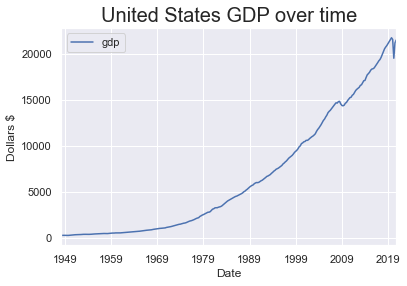

In [20]:
df['gdp'].plot()
plt.xlabel('Date')
plt.ylabel('Dollars $')
plt.title('United States GDP over time', fontsize = 20)
plt.legend()
plt.show()

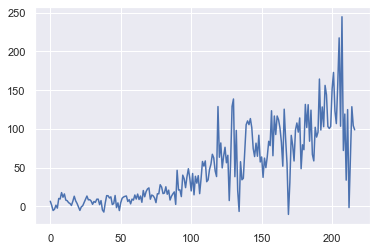

In [21]:
GDP_first_order = np.diff(y_train['gdp'])
plt.plot(GDP_first_order)

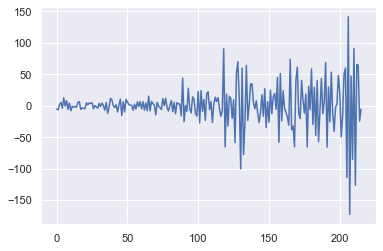

In [22]:
GDP_second_order = np.diff(GDP_first_order)
plt.plot(GDP_second_order)

In [23]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

def adf_test(timeseries):
    print ('Dickey-Fuller Test Result:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#define KPSS
def kpss_test(timeseries, trend='c'):
    print ('KPSS Test Result:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [24]:
adf_test(GDP_first_order)

Dickey-Fuller Test Result:
Test Statistic                  -0.320082
p-value                          0.922612
#Lags Used                      15.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [25]:
adf_gdp = adfuller(GDP_first_order)
ad_fuller_pval = adf_gdp[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: FALSE


In [26]:
adf_test(GDP_second_order)

Dickey-Fuller Test Result:
Test Statistic                -6.221139e+00
p-value                        5.219908e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.010000e+02
Critical Value (1%)           -3.463309e+00
Critical Value (5%)           -2.876029e+00
Critical Value (10%)          -2.574493e+00
dtype: float64


In [27]:
adf_gdp = adfuller(GDP_second_order)
ad_fuller_pval = adf_gdp[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [28]:
kpss_test(GDP_first_order)

KPSS Test Result:
Test Statistic            1.345519
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [29]:
kpss_gdp = kpss(GDP_first_order)
kpss_pval = kpss_gdp[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: FALSE


In [30]:
kpss_test(GDP_second_order)

KPSS Test Result:
Test Statistic            0.050236
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [31]:
kpss_gdp = kpss(GDP_second_order)
kpss_pval = kpss_gdp[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


### 2.B - 7 pts Create and interpret ACF and PACF plots
- For stationarity, the entire distribution of has to be constant over time, not only its mean. We can easily see the mean of the data is constant, and it’s standard deviation is too. As t increases, the standard deviation of the data actually decreases!

- From another point of view, non-stationarity is tied to special points in time, and here t = 0 is special, since p0 is fixed to 1 here. An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.
- For the PACF plot, the mean more or less remains constant. However there is more differences in standard deviation. We can also see more values that are not significant in this PACF plot throughout time.

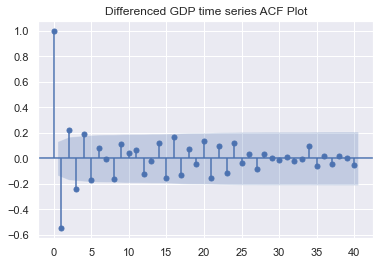

In [32]:
autocorr_plot = plot_acf(GDP_second_order, lags=40, title='Differenced GDP time series ACF Plot')

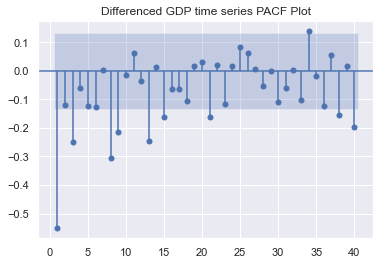

In [33]:
partial_autocorr_plot = plot_pacf(GDP_second_order, lags=40, title='Differenced GDP time series PACF Plot', zero = False)

### 2.C - 7 pts Fit an appropriate Box Jenkins model on training set

In [34]:
from sktime.forecasting.arima import ARIMA

In [35]:
df = pd.read_csv('hw3_data.csv', parse_dates = ['date'])

In [36]:
df

,date,gdp,urate
0,1948-01-01,265.742,3.4
1,1948-04-01,272.567,3.9
2,1948-07-01,279.196,3.6
3,1948-10-01,280.366,3.7
4,1949-01-01,275.034,4.3
...,...,...,...
287,2019-10-01,21747.394,3.6
288,2020-01-01,21561.139,3.5
289,2020-04-01,19520.114,14.8
290,2020-07-01,21170.252,10.2


<AxesSubplot:xlabel='date'>

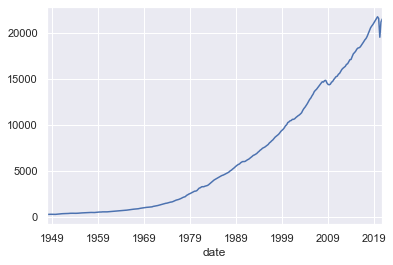

In [37]:
# selecting variable of intest & build uniform univariate time series
ts = df.groupby(pd.PeriodIndex(df['date'], freq="M"))['gdp'].mean()
ts.plot()

In [38]:
ts

date
1948-01      265.742
1948-04      272.567
1948-07      279.196
1948-10      280.366
1949-01      275.034
             ...    
2019-10    21747.394
2020-01    21561.139
2020-04    19520.114
2020-07    21170.252
2020-10    21494.731
Freq: M, Name: gdp, Length: 292, dtype: float64

In [39]:
#df = df.set_index(pd.DatetimeIndex(df['date']))
df.set_index('date', inplace = True)

In [40]:
adf_test(ts)

Dickey-Fuller Test Result:
Test Statistic                   3.522320
p-value                          1.000000
#Lags Used                       3.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64


In [41]:
kpss_test(ts)
# we reject the null hypothesis- the new dataset is not stationary

KPSS Test Result:
Test Statistic            1.669461
p-value                   0.010000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [42]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(ts)

## ARIMA

In [43]:
arima_model = ARIMA(order=(1,1,1))
model_fit = arima_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = arima_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

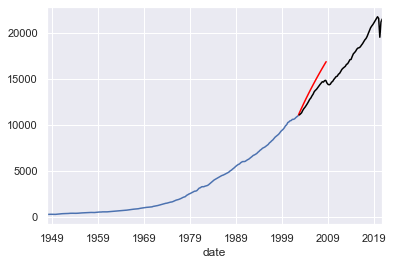

In [44]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

## MA of ARIMA

In [45]:
ma_model = ARIMA(order=(0,0,1))
model_fit = ma_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = ma_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

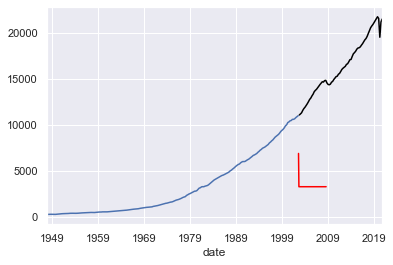

In [46]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

## AR of ARIMA

In [47]:
ar_model = ARIMA(order=(1,0,0))

In [48]:
model_fit = ar_model.fit(y_train)

In [49]:
fh = list(range(1, 1+len(y_test)))

In [50]:
y_pred = ar_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

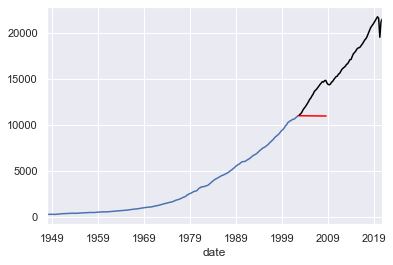

In [51]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

### 2.D - 7 pts Check residuals (scatter plot, histogram, ACF, portmanteau tests) Give a summary of your residuals.

### 2.E - 7 pts Print model evaluation metrics MAE, MSE, MAPE, sMAPE on test set

## 3. 35 pts – Box Jenkins model for Unemployment rate
### 3.A - 7 pts Perform transformations or differencing until you can visually and statistically prove stationarity on training set. Summarize the changes to your time series.

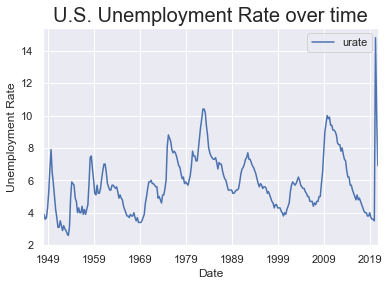

In [52]:
df['urate'].plot()
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('U.S. Unemployment Rate over time', fontsize = 20)
plt.legend()
plt.show()

In [53]:
y_train, y_test = temporal_train_test_split(df)

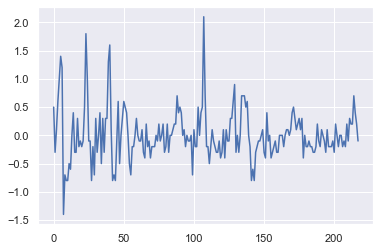

In [54]:
urate_first_order = np.diff(y_train['urate'])
plt.plot(urate_first_order)

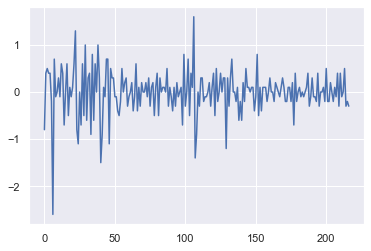

In [55]:
urate_second_order = np.diff(urate_first_order)
plt.plot(urate_second_order)

In [56]:
adf_test(urate_first_order)

Dickey-Fuller Test Result:
Test Statistic                  -5.277430
p-value                          0.000006
#Lags Used                       8.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


In [57]:
adf_urate = adfuller(urate_first_order)
ad_fuller_pval = adf_urate[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [58]:
kpss_test(urate_first_order)

KPSS Test Result:
Test Statistic            0.068683
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [59]:
kpss_urate = kpss(urate_first_order)
kpss_pval = kpss_urate[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


### 3.B - 7 pts Create and interpret ACF and PACF plots

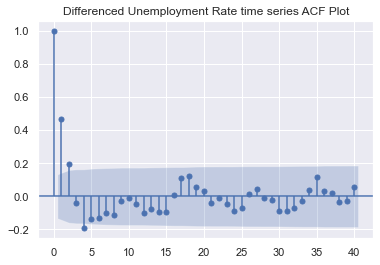

In [60]:
autocorr_plot = plot_acf(urate_first_order, lags=40, title='Differenced Unemployment Rate time series ACF Plot')

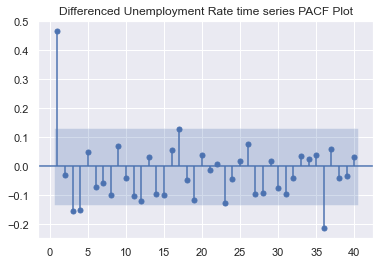

In [61]:
partial_autocorr_plot = plot_pacf(urate_first_order, lags=40, title='Differenced Unemployment Rate time series PACF Plot', zero = False)

### 3.C - 7 pts Fit an appropriate Box Jenkins model on training set

In [62]:
df = pd.read_csv('hw3_data.csv', parse_dates = ['date'])

<AxesSubplot:xlabel='date'>

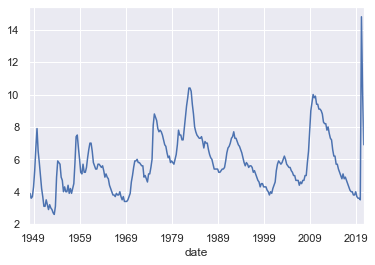

In [63]:
# selecting variable of intest & build uniform univariate time series
ts = df.groupby(pd.PeriodIndex(df['date'], freq="M"))['urate'].mean()
ts.plot()

In [64]:
df.set_index('date', inplace = True)

In [65]:
adf_test(ts)

Dickey-Fuller Test Result:
Test Statistic                  -4.385167
p-value                          0.000315
#Lags Used                       0.000000
Number of Observations Used    291.000000
Critical Value (1%)             -3.453023
Critical Value (5%)             -2.871524
Critical Value (10%)            -2.572090
dtype: float64


In [66]:
kpss_test(ts)
# cannot reject the null hypothesis- the new dataset is stationary

KPSS Test Result:
Test Statistic            0.314287
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


## ARIMA

In [67]:
y_train, y_test = temporal_train_test_split(ts)

In [68]:
arima_model = ARIMA(order=(1,1,1))
arima_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = arima_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

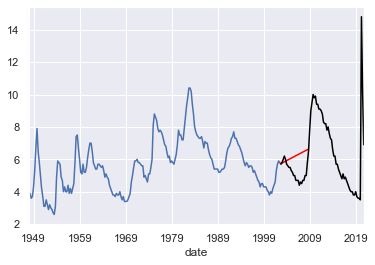

In [69]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

## MA of ARIMA

In [70]:
ma_model = ARIMA(order=(0,0,1))
ma_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = ma_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

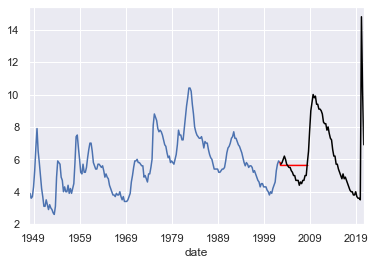

In [71]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

## AR of ARIMA

In [72]:
ar_model = ARIMA(order=(1,0,0))

In [73]:
model_fit = ar_model.fit(y_train)

In [74]:
fh = list(range(1, 1+len(y_test)))

In [75]:
y_pred = ar_model.predict(fh=fh )

<AxesSubplot:xlabel='date'>

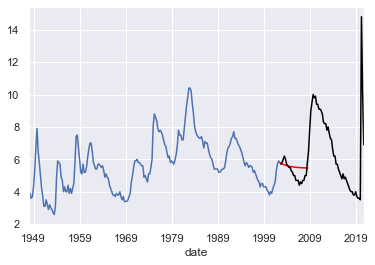

In [76]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

### 3.D - 7 pts Check residuals (scatter plot, histogram, ACF, portmanteau tests)  Give a summary of your residuals.

### 3.E - 7 pts Print model evaluation metrics MAE, MSE, MAPE, sMAPE on test set

## 4. 10 pts – Evaluation Compare the two models’ performance using the error metrics as evidence